In [ ]:
#Este cuaderno de Jupyter procesa de manera local 
#el modelo generado en tensorflow lite para la detección de razas de perros

In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import os

# --- INSTRUCCIONES PARA EJECUTAR LOCALMENTE EN TU PC ---
# 1. Asegúrate de tener Python instalado (versión 3.8 o superior).
# 2. Abre tu terminal (Símbolo del sistema en Windows, Terminal en macOS/Linux).
# 3. Instala las librerías necesarias ejecutando:
#    pip install tensorflow Pillow matplotlib requests
# 4. Coloca este script (ej. test_model.py) en una carpeta, por ejemplo 'mi_proyecto_perros'.
# 5. Dentro de 'mi_proyecto_perros', crea una subcarpeta llamada 'tflite_models'.
# 6. Copia tus archivos 'stanford_dogs_classifier.tflite' y 'labels.txt' dentro de 'tflite_models'.
# 7. Edita la variable 'IMAGE_TO_TEST' más abajo con la ruta a tu imagen local o una URL.
#    Si es una imagen local, colócala en la carpeta 'mi_proyecto_perros'.
# 8. Desde tu terminal, navega a la carpeta 'mi_proyecto_perros' y ejecuta:
#    python test_model.py
# -----------------------------------------------------


In [2]:
# --- Bloque 1: Carga de Archivos Necesarios ---

# Ruta a tu modelo TFLite
# Asegúrate de que esta ruta es correcta relative a donde ejecutas el script.
TFLITE_MODEL_PATH = 'stanford_dogs_classifier.tflite'
# Ruta a tu archivo de etiquetas
LABELS_PATH = 'labels.txt'

# Verificar que los archivos existen
if not os.path.exists(TFLITE_MODEL_PATH):
    print(f"Error: Modelo TFLite no encontrado en '{TFLITE_MODEL_PATH}'")
    print("Asegúrate de que el archivo 'stanford_dogs_classifier.tflite' esté en la carpeta 'tflite_models/'.")
    exit() # Termina el script si el archivo no se encuentra
if not os.path.exists(LABELS_PATH):
    print(f"Error: Archivo de etiquetas no encontrado en '{LABELS_PATH}'")
    print("Asegúrate de que el archivo 'labels.txt' esté en la carpeta 'tflite_models/'.")
    exit() # Termina el script si el archivo no se encuentra

# Cargar el intérprete de TensorFlow Lite
interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_PATH)
interpreter.allocate_tensors()

# Obtener los detalles de las entradas y salidas del modelo
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Obtener el tamaño de entrada esperado por el modelo
# Debería ser (1, 224, 224, 3) para MobileNetV2
input_shape = input_details[0]['shape']
IMG_SIZE = input_shape[1] # Debería ser 224

print(f"Modelo cargado. Tamaño de entrada esperado: {input_shape}")

# Cargar las etiquetas de las razas
with open(LABELS_PATH, 'r') as f:
    labels = [line.strip() for line in f.readlines()]
print(f"Etiquetas cargadas. Total: {len(labels)} razas.")


Modelo cargado. Tamaño de entrada esperado: [  1 224 224   3]
Etiquetas cargadas. Total: 120 razas.


In [3]:
# --- Bloque 2: Función de Preprocesamiento de Imagen ---
def preprocess_image_for_model(image_path_or_url):
    """
    Carga una imagen desde una ruta local o URL y la preprocesa para el modelo TFLite.
    """
    if image_path_or_url.startswith('http'):
        response = requests.get(image_path_or_url)
        image = Image.open(BytesIO(response.content)).convert('RGB')
        print(f"Imagen cargada desde URL: {image_path_or_url}")
    else:
        # Abre la imagen desde una ruta local
        image = Image.open(image_path_or_url).convert('RGB')
        print(f"Imagen cargada desde archivo local: {image_path_or_url}")

    # Redimensionar la imagen
    image = image.resize((IMG_SIZE, IMG_SIZE))
    # Convertir a array NumPy y normalizar a [-1, 1]
    input_data = np.array(image, dtype=np.float32)
    input_data = (input_data / 127.5) - 1.0
    # Añadir una dimensión de batch (1, IMG_SIZE, IMG_SIZE, 3)
    input_data = np.expand_dims(input_data, axis=0)

    return input_data, image # También retorna la imagen original para visualización

In [37]:
# --- Bloque 3: Realizar Inferencia y Mostrar Resultado ---

# Cambia esto por la URL o ruta local de tu imagen de prueba
# EJEMPLO DE URL:
# IMAGE_TO_TEST = 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c5/Golden_Retriever_Male_-_Happy_Dog_%281694291880%29.jpg/800px-Golden_Retriever_Male_-_Happy_Dog_%281694291880%29.jpg'

# EJEMPLO DE RUTA LOCAL (si guardas la imagen 'mi_perro1.jpg' en la misma carpeta que el script):
IMAGE_TO_TEST = 'mi_perro1.jpeg' # Cambia esto por el nombre de tu imagen local

# Preprocesar la imagen
input_data, original_image = preprocess_image_for_model(IMAGE_TO_TEST)

# Asignar los tensores de entrada y ejecutar la inferencia
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# Obtener los resultados de la inferencia
output_data = interpreter.get_tensor(output_details[0]['index'])

# El modelo devuelve logits (si no se añadió Softmax en la conversión) o probabilidades.
# La heurística `np.all(output_data >= -1.0) and np.all(output_data <= 1.0)`
# intenta detectar si la salida está en un rango de logits (valores típicamente entre -inf y +inf, pero
# cuando ya han sido convertidos a float32, pueden estar escalados, por lo que es una heurística
# aproximada para diferenciar de probabilidades que están entre 0 y 1).
# Si durante la conversión a TFLite incluiste la capa Softmax, output_data ya serán probabilidades.
# Si no la incluiste, aplica Softmax aquí.
# Nuestro script de Colab incluye Softmax, así que output_data ya debería ser probabilidades.
if np.all(output_data >= -1.0) and np.all(output_data <= 1.0) and not (np.all(output_data >= 0.0) and np.all(output_data <= 1.0)):
    # Si las activaciones no son Softmax y están en un rango que sugiere logits, aplicamos Softmax manualmente
    probabilities = tf.nn.softmax(output_data).numpy()[0]
else:
    # Si ya son probabilidades (rango 0 a 1), las usamos directamente
    probabilities = output_data[0]

# Obtener el índice de la clase con mayor probabilidad
predicted_class_id = np.argmax(probabilities)
predicted_class_name = labels[predicted_class_id]
confidence = probabilities[predicted_class_id] * 100 # Convertir a porcentaje

Imagen cargada desde archivo local: mi_perro1.jpeg


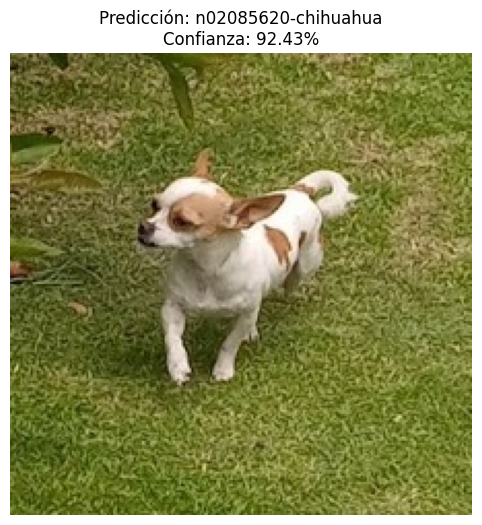


--- Resultado de la Clasificación ---
Imagen de prueba: mi_perro1.jpeg
Raza Predicha: n02085620-chihuahua
Confianza: 92.43%


In [38]:
# --- Bloque 4: Mostrar Resultados ---
plt.figure(figsize=(8, 6))
plt.imshow(original_image)
plt.title(f"Predicción: {predicted_class_name}\nConfianza: {confidence:.2f}%")
plt.axis('off')
plt.show()

print(f"\n--- Resultado de la Clasificación ---")
print(f"Imagen de prueba: {IMAGE_TO_TEST}")
print(f"Raza Predicha: {predicted_class_name}")
print(f"Confianza: {confidence:.2f}%")
